In [1]:
# Parameters
nPC = 30
batchKeys = "chemistry"
queryDataset = "EXTERNAL"


In [2]:
for v in ['nPC','batchKeys', 'queryDataset']:
    if v in locals() or v in globals():
        print(f"{v} = {eval(v)}")
    else:
        raise Exception(f"{v} not specified")

nPC = 30
batchKeys = chemistry
queryDataset = EXTERNAL


In [3]:
import os

import scanpy as sc
import pandas as pd
import numpy as np

import symphonypy as sp

from sklearn.metrics import balanced_accuracy_score

from pyprojroot import here

random_seed = 42

### Defining functions

In [4]:
def train_classifier(adataTrain = None, cell_type_col = None, y_true_col = None, max_iter=10000,random_state = 25, model = 'LinearSVC'):
    
    import pandas as pd
    from tqdm import tqdm
    from sklearn.svm import LinearSVC, SVC

    from sklearn.metrics import balanced_accuracy_score
    
    clfList = dict()
    trainAccuracy = []
    for ct_ in tqdm(adataTrain.obs[cell_type_col].unique()):
        clfList[ct_] = dict()
        X_i = adataTrain.X[adataTrain.obs[cell_type_col] == ct_]
        y_true_i = adataTrain.obs[y_true_col][adataTrain.obs[cell_type_col] == ct_]

        if mode == 'LinearSVC':
            clfList[ct_]['clf'] = LinearSVC(max_iter=max_iter, dual = True, random_state = random_state).fit(X_i, y_true_i)
        elif mode == 'SVC':
            clfList[ct_]['clf'] = SVC(max_iter=max_iter, random_state = random_state).fit(X_i, y_true_i)
            
        clfList[ct_]['bAcc'] = balanced_accuracy_score(y_true = y_true_i, y_pred = clfList[ct_]['clf'].predict(X_i))
        clfList[ct_]['nObs'] = len(y_true_i)

    return clfList
    
def vote_disease(adataTest = None, clfList = None, cell_type_col = None, sample_id_col = None):

    from tqdm import tqdm
    import pandas as pd

    
    
    classificationDF = pd.DataFrame()
    for ct_ in tqdm(adataTest.obs[cell_type_col].unique()):
        X_i = adataTest.X[adataTest.obs[cell_type_col] == ct_]
        PID_i = adataTest.obs[sample_id_col][adataTest.obs[cell_type_col] == ct_]
        if ct_ not in clfList:
            print(f"{ct_} is missing in training set")
            continue
        DF_i = pd.DataFrame.from_dict({
            sample_id_col: PID_i,
            f"{ct_}_prediction": clfList[ct_]['clf'].predict(X_i)
        })
        if classificationDF.shape[0] == 0:
            classificationDF = DF_i
        else:
            classificationDF = classificationDF.merge(DF_i, how='outer', on = sample_id_col)
    classificationDF['firstChoice'] = ''
    classificationDF['firstChoice_perc'] = np.nan
    classificationDF['secondChoice'] = ''
    classificationDF['secondChoice_perc'] = np.nan
    
    for i in tqdm(range(classificationDF.shape[0])):
        vote_i = classificationDF.loc[i,classificationDF.columns !=sample_id_col].value_counts()
        vote_i /= (vote_i.sum() / 100)
        res_i = vote_i.sort_values(ascending=False)
        classificationDF.loc[i,'firstChoice'] = res_i.index[0]
        classificationDF.loc[i,'firstChoice_perc'] = res_i.iloc[0]
        if res_i.shape[0] > 1:
            classificationDF.loc[i,'secondChoice'] = res_i.index[1]
            classificationDF.loc[i,'secondChoice_perc'] = res_i.iloc[1]

    return classificationDF
    
def aggregating_features(Z = None, obsDF = None, mode = 'mean', obs_names_col = [], min_observation = 0):
    Zdf = pd.DataFrame(Z)
    for c in obsDF.columns:
        Zdf[c] = obsDF[c].tolist()

    grpDF = Zdf.groupby(obsDF.columns.tolist(), observed = True)

    nCount = grpDF.size().to_frame('n_observation')
    
    if mode in ['mean','avarage']:
        Zaggr = grpDF.mean()
    elif mode == 'sum':
        Zaggr = grpDF.sum()
    else:
        raise ValueError(f"mode {mode} not supported. Available mode are 'mean' or 'sum'")

    grpObs = pd.DataFrame(Zaggr.index.tolist(), columns=obsDF.columns.tolist()).merge(pd.DataFrame(nCount).reset_index(), on = obsDF.columns.tolist())

    if len(obs_names_col) == 0:
        grpAdata  = sc.AnnData(X = np.array(Zaggr), obs = grpObs)
    elif all([c in obsDF.columns.tolist() for c in obs_names_col]):
        grpObs.index = grpObs[obs_names_col].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        grpAdata  = sc.AnnData(X = np.array(Zaggr), obs = grpObs)
    else:
        raise ValueError(f"Impossible to use {obs_names_col} as index. It's not present in obsDF")

    if min_observation > 0:
        grpAdata = grpAdata[grpAdata.obs.n_observation >= min_observation]
    return grpAdata

### Parameters

In [5]:
batch_key_query = batchKeys.split(',')
batch_key_query

['chemistry']

### Loading dataset

**Integrated object**

In [6]:
adataR = sc.read_h5ad(here(f"03_downstream_analysis/08_PatientClassifier/Harmony_Symphony/results/01_MAIN_HarmonyIntegrated_{nPC}nPC_Batch_{batchKeys}.h5ad"), backed='r')
adataR

AnnData object with n_obs × n_vars = 4435922 × 8253 backed at '/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/03_downstream_analysis/08_PatientClassifier/Harmony_Symphony/results/01_MAIN_HarmonyIntegrated_30nPC_Batch_chemistry.h5ad'
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'disease', 'sex', 'binned_age', 'Level1', 'Level2'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'highly_variable', 'mean', 'std'
    uns: 'harmony', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

**Query dataset**

In [7]:
adataQ = sc.read_h5ad(here(f'03_downstream_analysis/02_gene_universe_definition/results/05_{queryDataset}_geneUniverse.h5ad'))
adataQ

AnnData object with n_obs × n_vars = 572872 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'disease', 'sex', 'binned_age'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

### Preprocessing

In [8]:
sc.pp.normalize_total(adataQ, target_sum=1e4)
sc.pp.log1p(adataQ)

### Projection with Symphony

In [9]:
sp.tl.map_embedding(adataQ, adataR, key=batch_key_query)

In [10]:
sp.tl.per_cell_confidence(adataQ, adataR)

<Axes: >

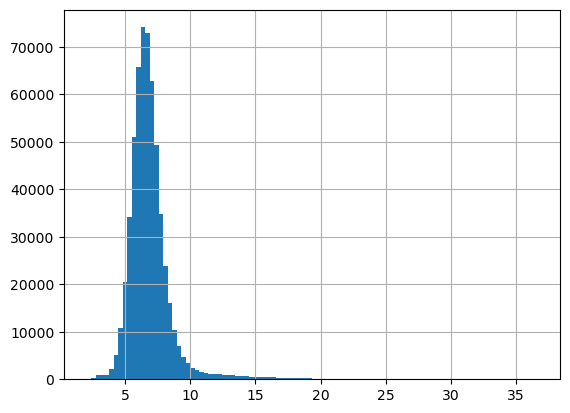

In [11]:
adataQ.obs.symphony_per_cell_dist.hist(bins=100)

In [12]:
adataQ

AnnData object with n_obs × n_vars = 572872 × 8253
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'disease', 'sex', 'binned_age', 'symphony_per_cell_dist'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'
    uns: 'log1p'
    obsm: 'X_pca_reference', 'X_pca_harmony', 'X_pca_harmony_symphony_R'

### Label transfer

In [13]:
# common embedded space -> adataQ.obsm['X_pca_harmony']

**Level1 Annotation**

In [14]:
sp.tl.transfer_labels_kNN(adataQ, adataR, 'Level1', ref_basis = 'X_pca_harmony', query_basis = 'X_pca_harmony')

**Disease**

In [15]:
adataQ.obs.rename({'disease':'disease_true'}, axis=1, inplace=True)

In [16]:
sp.tl.transfer_labels_kNN(adataQ, adataR, 'disease', ref_basis = 'X_pca_harmony', query_basis = 'X_pca_harmony')

In [17]:
adataQ.obs.rename({'disease':'disease_pred'}, axis=1, inplace=True)

In [18]:
balanced_accuracy_score(y_true = adataQ.obs.disease_true, y_pred=adataQ.obs.disease_pred)

/scratch_isilon/groups/singlecell/shared/conda_env/inflammation_atlas_R1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.15391660202587226

In [19]:
adataQ.obs

,studyID,libraryID,sampleID,chemistry,technology,disease_true,sex,binned_age,symphony_per_cell_dist,Level1,disease_pred
cellID,,,,,,,,,,,
SCGT00val_L006_I036016_T0_AAACCCAAGACAACTA,SCGT00val,SCGT00val_L006,SCGT00val_I036016_T0,3_GEX_V3,3_GEX_V3_GenoHashed,RA,female,31-40,4.646586,T_CD4_Naive,HIV
SCGT00val_L006_I036023_T0_AAACCCAAGACGGAAA,SCGT00val,SCGT00val_L006,SCGT00val_I036023_T0,3_GEX_V3,3_GEX_V3_GenoHashed,RA,female,51-60,6.265153,T_CD4_NonNaive,RA
SCGT00val_L006_I036016_T0_AAACCCAAGAGCATTA,SCGT00val,SCGT00val_L006,SCGT00val_I036016_T0,3_GEX_V3,3_GEX_V3_GenoHashed,RA,female,31-40,4.735890,T_CD4_Naive,PS
SCGT00val_L006_I036021_T0_AAACCCAAGATGGTCG,SCGT00val,SCGT00val_L006,SCGT00val_I036021_T0,3_GEX_V3,3_GEX_V3_GenoHashed,RA,female,61-70,6.743922,T_CD8_NonNaive,SLE
SCGT00val_L006_I036021_T0_AAACCCAAGCAACAAT,SCGT00val,SCGT00val_L006,SCGT00val_I036021_T0,3_GEX_V3,3_GEX_V3_GenoHashed,RA,female,61-70,14.326670,DC,PS
...,...,...,...,...,...,...,...,...,...,...,...
10XGenomics_L008_10XHC8_T0_TTTGTCATCCACGTTC,10XGenomics,10XGenomics_L008,10XGenomics_10XHC8_T0,5_GEX_V2,5_GEX_V2,healthy,na,NaN,5.402700,B,healthy
10XGenomics_L008_10XHC8_T0_TTTGTCATCCCGACTT,10XGenomics,10XGenomics_L008,10XGenomics_10XHC8_T0,5_GEX_V2,5_GEX_V2,healthy,na,NaN,4.523652,T_CD4_Naive,healthy
10XGenomics_L008_10XHC8_T0_TTTGTCATCGTGGGAA,10XGenomics,10XGenomics_L008,10XGenomics_10XHC8_T0,5_GEX_V2,5_GEX_V2,healthy,na,NaN,6.334835,T_CD4_Naive,healthy


### Generating pseudobulk from latent space for Q dataset

In [20]:
emb_pseudobulk_Q = aggregating_features(Z = adataQ.obsm['X_pca_harmony'], obsDF = adataQ.obs[['sampleID','Level1','disease_true']], mode = 'mean', obs_names_col=['sampleID','Level1'])

In [21]:
emb_pseudobulk_Q.obs

,sampleID,Level1,disease_true,n_observation
10XGenomics_10XHC1_T0_B,10XGenomics_10XHC1_T0,B,healthy,977
10XGenomics_10XHC1_T0_Cycling_cells,10XGenomics_10XHC1_T0,Cycling_cells,healthy,21
10XGenomics_10XHC1_T0_DC,10XGenomics_10XHC1_T0,DC,healthy,130
10XGenomics_10XHC1_T0_ILC,10XGenomics_10XHC1_T0,ILC,healthy,315
10XGenomics_10XHC1_T0_Mono,10XGenomics_10XHC1_T0,Mono,healthy,1460
...,...,...,...,...
Savage2021_PIDB_T0_T_CD4_NonNaive,Savage2021_PIDB_T0,T_CD4_NonNaive,healthy,1682
Savage2021_PIDB_T0_T_CD8_Naive,Savage2021_PIDB_T0,T_CD8_Naive,healthy,395
Savage2021_PIDB_T0_T_CD8_NonNaive,Savage2021_PIDB_T0,T_CD8_NonNaive,healthy,2434
Savage2021_PIDB_T0_UTC,Savage2021_PIDB_T0,UTC,healthy,236


**Loading training pseudobulk**

In [22]:
emb_pseudobulk_train = sc.read_h5ad(here(f"03_downstream_analysis/08_PatientClassifier/Harmony_Symphony/results/01_MAIN_HarmonyIntegrated_PSEUDOBULK_{nPC}nPC_Batch_{batchKeys}.h5ad"))

#### Remove unwanted cell types

In [23]:
emb_pseudobulk_train = emb_pseudobulk_train[~emb_pseudobulk_train.obs.Level1.isin(['Cycling_cells','RBC','Progenitors','Platelets']),]

In [24]:
emb_pseudobulk_Q = emb_pseudobulk_Q[~emb_pseudobulk_Q.obs.Level1.isin(['Cycling_cells','RBC','Progenitors','Platelets']),]

### Saving query dataset and pseudobulks

In [25]:
adataQ.write(here(f"03_downstream_analysis/08_PatientClassifier/Harmony_Symphony/results/02_{queryDataset}_SymphonyProjected_{nPC}nPC_Batch_{batchKeys}.h5ad"), 
             compression='gzip')

In [26]:
emb_pseudobulk_Q.write(here(f"03_downstream_analysis/08_PatientClassifier/Harmony_Symphony/results/02_{queryDataset}_SymphonyProjected_PSEUDOBULK{nPC}nPC_Batch_{batchKeys}.h5ad"), 
             compression='gzip')

/scratch_isilon/groups/singlecell/shared/conda_env/inflammation_atlas_R1/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/scratch_isilon/groups/singlecell/shared/conda_env/inflammation_atlas_R1/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/scratch_isilon/groups/singlecell/shared/conda_env/inflammation_atlas_R1/lib/python3.10/site-packages/anndata/_core/anndata.py:1301: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


### Training linear classifiers

In [27]:
def train_classifier(adataTrain = None, cell_type_col = None, y_true_col = None, max_iter=10000,random_state = 25, model = 'LinearSVC', kargs_model = None):
    
    import pandas as pd
    from tqdm import tqdm
    from sklearn.svm import LinearSVC, SVC
    from sklearn.neighbors import KNeighborsClassifier

    from sklearn.metrics import balanced_accuracy_score
    
    clfList = dict()
    trainAccuracy = []
    for ct_ in tqdm(adataTrain.obs[cell_type_col].unique()):
        clfList[ct_] = dict()
        X_i = adataTrain.X[adataTrain.obs[cell_type_col] == ct_]
        y_true_i = adataTrain.obs[y_true_col][adataTrain.obs[cell_type_col] == ct_]

        if model == 'LinearSVC':
            clfList[ct_]['clf'] = LinearSVC(**kargs_model).fit(X_i, y_true_i) # max_iter=max_iter, dual = True, random_state = random_state
        elif model == 'SVC':
            clfList[ct_]['clf'] = SVC(**kargs_model).fit(X_i, y_true_i) # max_iter=max_iter, random_state = random_state
        elif model == 'KNeighborsClassifier':
            clfList[ct_]['clf'] = KNeighborsClassifier(**kargs_model).fit(X_i, y_true_i) # n_neighbors = 5, weights='distance', n_jobs = -1
            
            
        clfList[ct_]['bAcc'] = balanced_accuracy_score(y_true = y_true_i, y_pred = clfList[ct_]['clf'].predict(X_i))
        clfList[ct_]['nObs'] = len(y_true_i)

    return clfList
    
def vote_disease(adataTest = None, clfList = None, cell_type_col = None, sample_id_col = None):

    from tqdm import tqdm
    import pandas as pd
    
    classificationDF = pd.DataFrame()
    for ct_ in tqdm(adataTest.obs[cell_type_col].unique()):
        X_i = adataTest.X[adataTest.obs[cell_type_col] == ct_]
        PID_i = adataTest.obs[sample_id_col][adataTest.obs[cell_type_col] == ct_]
        if ct_ not in clfList:
            print(f"{ct_} is missing in training set")
            continue
        DF_i = pd.DataFrame.from_dict({
            sample_id_col: PID_i,
            f"{ct_}_prediction": clfList[ct_]['clf'].predict(X_i)
        })
        if classificationDF.shape[0] == 0:
            classificationDF = DF_i
        else:
            classificationDF = classificationDF.merge(DF_i, how='outer', on = sample_id_col)
    classificationDF['firstChoice'] = ''
    classificationDF['firstChoice_perc'] = np.nan
    classificationDF['secondChoice'] = ''
    classificationDF['secondChoice_perc'] = np.nan
    
    for i in tqdm(range(classificationDF.shape[0])):
        vote_i = classificationDF.loc[i,classificationDF.columns !=sample_id_col].value_counts()
        vote_i /= (vote_i.sum() / 100)
        res_i = vote_i.sort_values(ascending=False)
        classificationDF.loc[i,'firstChoice'] = res_i.index[0]
        classificationDF.loc[i,'firstChoice_perc'] = res_i.iloc[0]
        if res_i.shape[0] > 1:
            classificationDF.loc[i,'secondChoice'] = res_i.index[1]
            classificationDF.loc[i,'secondChoice_perc'] = res_i.iloc[1]

    return classificationDF
    
def aggregating_features(Z = None, obsDF = None, mode = 'mean', obs_names_col = []):
    Zdf = pd.DataFrame(Z)
    for c in obsDF.columns:
        Zdf[c] = obsDF[c].tolist()
    if mode in ['mean','avarage']:
        Zaggr = Zdf.groupby(obsDF.columns.tolist(), observed = True).mean()
    elif mode == 'sum':
        Zaggr = Zdf.groupby(obsDF.columns.tolist(), observed = True).sum()
    else:
        raise ValueError(f"mode {mode} not supported. Available mode are 'mean' or 'sum'")

    grpObs = pd.DataFrame(Zaggr.index.tolist(), columns=obsDF.columns.tolist())

    if len(obs_names_col) == 0:
        grpAdata  = sc.AnnData(X = np.array(Zaggr), obs = grpObs, )
    elif all([c in obsDF.columns.tolist() for c in obs_names_col]):
        grpObs.index = grpObs[obs_names_col].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        grpAdata  = sc.AnnData(X = np.array(Zaggr), obs = grpObs)
    else:
        raise ValueError(f"Impossible to use {obs_names_col} as index. It's not present in obsDF")
    return grpAdata

In [28]:
clfList = train_classifier(adataTrain = emb_pseudobulk_train, cell_type_col = 'Level1', y_true_col = 'disease', max_iter=-1, random_state = 25, model = 'KNeighborsClassifier', 
                           kargs_model={'n_neighbors':2, 'weights':'uniform', 'metric':'cosine','n_jobs':-1})

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.19it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.32it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.39it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.79it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.44it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.35it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.32it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.74it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.42it/s]

100%|██████████| 11/11 [00:02<00:00,  5.90it/s]

100%|██████████| 11/11 [00:02<00:00,  5.22it/s]

In [29]:
clfList

{'B': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8693252895768376,
  'nObs': 814},
 'DC': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8424103003436034,
  'nObs': 801},
 'ILC': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.840509169810504,
  'nObs': 817},
 'Mono': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8466963712645701,
  'nObs': 817},
 'Plasma': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.7983383904500665,
  'nObs': 727},
 'T_CD4_Naive': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.8974200067736948,
  'nObs': 814},
 'T_CD4_NonNaive': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'bAcc': 0.900335491533165,
  'nObs': 816},
 'T_CD8_Naive': {'clf': KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=2),
  'b

### Predicting diseases

In [30]:
emb_pseudobulk_Q.obs

,sampleID,Level1,disease_true,n_observation
10XGenomics_10XHC1_T0_B,10XGenomics_10XHC1_T0,B,healthy,977
10XGenomics_10XHC1_T0_DC,10XGenomics_10XHC1_T0,DC,healthy,130
10XGenomics_10XHC1_T0_ILC,10XGenomics_10XHC1_T0,ILC,healthy,315
10XGenomics_10XHC1_T0_Mono,10XGenomics_10XHC1_T0,Mono,healthy,1460
10XGenomics_10XHC1_T0_Plasma,10XGenomics_10XHC1_T0,Plasma,healthy,4
...,...,...,...,...
Savage2021_PIDB_T0_T_CD4_NonNaive,Savage2021_PIDB_T0,T_CD4_NonNaive,healthy,1682
Savage2021_PIDB_T0_T_CD8_Naive,Savage2021_PIDB_T0,T_CD8_Naive,healthy,395
Savage2021_PIDB_T0_T_CD8_NonNaive,Savage2021_PIDB_T0,T_CD8_NonNaive,healthy,2434
Savage2021_PIDB_T0_UTC,Savage2021_PIDB_T0,UTC,healthy,236


In [31]:
classificationDF = vote_disease(adataTest = emb_pseudobulk_Q, 
                                clfList = clfList, 
                                sample_id_col = 'sampleID',
                                cell_type_col = 'Level1')


  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.35it/s]

 91%|█████████ | 10/11 [00:00<00:00, 43.17it/s]

100%|██████████| 11/11 [00:00<00:00, 43.14it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

100%|██████████| 86/86 [00:00<00:00, 931.73it/s]

In [32]:
res = classificationDF.merge(emb_pseudobulk_Q.obs[['sampleID', 'disease_true']].drop_duplicates(), how = 'left', on = 'sampleID').set_index('sampleID')


In [33]:
balanced_accuracy_score(y_true = res.disease_true, y_pred=res.firstChoice)

/scratch_isilon/groups/singlecell/shared/conda_env/inflammation_atlas_R1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.16253063725490197

In [34]:
res

,B_prediction,DC_prediction,ILC_prediction,Mono_prediction,Plasma_prediction,T_CD4_Naive_prediction,T_CD4_NonNaive_prediction,T_CD8_Naive_prediction,T_CD8_NonNaive_prediction,UTC_prediction,pDC_prediction,firstChoice,firstChoice_perc,secondChoice,secondChoice_perc,disease_true
sampleID,,,,,,,,,,,,,,,,
10XGenomics_10XHC1_T0,NPC,healthy,healthy,SLE,NPC,NPC,NPC,NPC,healthy,NPC,healthy,NPC,46.153846,healthy,30.769231,healthy
10XGenomics_10XHC2_T0,NPC,healthy,NPC,flu,COVID,NPC,NPC,NPC,healthy,NPC,healthy,NPC,46.153846,healthy,23.076923,healthy
10XGenomics_10XHC3_T0,NPC,healthy,healthy,HIV,SLE,NPC,NPC,healthy,healthy,NPC,healthy,healthy,38.461538,NPC,30.769231,healthy
10XGenomics_10XHC4_T0,SLE,COPD,COPD,SLE,SLE,healthy,healthy,healthy,NPC,NPC,healthy,healthy,30.769231,SLE,23.076923,healthy
10XGenomics_10XHC5_T0,healthy,COPD,COPD,SLE,SLE,healthy,healthy,healthy,healthy,healthy,healthy,healthy,53.846154,COPD,15.384615,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Savage2021_BRISL5_T0,HNSCC,SLE,HNSCC,COVID,HNSCC,healthy,NPC,NPC,COVID,HNSCC,COVID,HNSCC,30.769231,COVID,23.076923,SLE
Savage2021_BRISL6_T0,HNSCC,flu,HNSCC,healthy,COVID,HNSCC,NPC,NPC,HNSCC,HNSCC,healthy,HNSCC,38.461538,healthy,15.384615,SLE
Savage2021_BRISL7_T0,HNSCC,HNSCC,COVID,HNSCC,COVID,NPC,NPC,NPC,COVID,NPC,HNSCC,HNSCC,30.769231,NPC,30.769231,SLE
